https://towardsdatascience.com/forecasting-with-technical-indicators-and-gru-lstm-rnn-multivariate-time-series-a3244dcbc38b

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

os.chdir("../marketdata")
import alpaca

os.chdir("../technicals")
import technicals

In [2]:
# fix random seed for reproducibility
np.random.seed(42)

## Import data

In [3]:
# set market data date range 
from datetime import date, datetime, timedelta

end_date  = datetime.now()
start_date  = (end_date - timedelta(days=1000))

start_date = start_date.strftime('%Y-%m-%d')
end_date = end_date.strftime('%Y-%m-%d')

print(f"Start date : {start_date}")
print(f"End date : {end_date}")

Start date : 2018-10-16
End date : 2021-07-12


In [4]:
# load the dataset
test_tickers = ["ADSK"]
ohlcv_df = alpaca.ohlcv(test_tickers, start_date=start_date, end_date=end_date)
tech_ind = technicals.TechnicalAnalysis(ohlcv_df)

df = tech_ind.get_all_technicals(test_tickers[0])
df.head()

,open,high,low,close,volume,rsi,williams,mfi,stoch_k,macd,...,ema_7,ema_14,ema_21,highlow,closeopen,bb_high,bb_low,pvt,daily_return,cum_daily_return
time,,,,,,,,,,,,,,,,,,,,,
2018-10-16 00:00:00-04:00,137.7500,141.80,136.6200,141.42,2011114,0.000000,0.0,0.0,0.0,0.000000,...,141.420000,141.420000,141.420000,5.1800,3.6700,0.0,0.0,0.000000,0.000000,1.000000
2018-10-17 00:00:00-04:00,141.1800,142.10,138.7000,141.82,1295773,100.000000,0.0,0.0,0.0,0.008974,...,141.648571,141.634286,141.629524,3.4000,0.6400,0.0,0.0,0.000000,0.002828,1.002828
2018-10-18 00:00:00-04:00,140.7600,141.45,135.7600,137.28,1793153,55.226824,0.0,0.0,0.0,-0.129350,...,139.759459,139.970934,140.039517,5.6900,-3.4800,0.0,0.0,-61068.183852,-0.032012,0.970725
2018-10-19 00:00:00-04:00,138.8099,140.43,133.1001,133.18,2883838,38.533373,0.0,0.0,0.0,-0.337122,...,137.353257,137.893396,138.072265,7.3299,-5.6299,0.0,0.0,-28725.462394,-0.029866,0.941734
2018-10-22 00:00:00-04:00,133.9300,137.31,131.4500,135.64,1575925,48.534072,0.0,0.0,0.0,-0.345035,...,136.791677,137.305488,137.488969,5.8600,1.7100,0.0,0.0,115237.903532,0.018471,0.959129


## Data preparation

In [5]:
print(f"Dataset has {df.shape[0]} samples, and {df.shape[1]} features")

Dataset has 686 samples, and 23 features


In [6]:
# drop 'volume'
df = df.drop(columns=['cum_daily_return','pvt','highlow','closeopen','ma_200'])

In [7]:
# fill NaN values with 0
df = df.fillna(0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 686 entries, 2018-10-16 00:00:00-04:00 to 2021-07-12 00:00:00-04:00
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          686 non-null    float64
 1   high          686 non-null    float64
 2   low           686 non-null    float64
 3   close         686 non-null    float64
 4   volume        686 non-null    int64  
 5   rsi           686 non-null    float64
 6   williams      686 non-null    float64
 7   mfi           686 non-null    float64
 8   stoch_k       686 non-null    float64
 9   macd          686 non-null    float64
 10  ma_10         686 non-null    float64
 11  ma_50         686 non-null    float64
 12  ema_7         686 non-null    float64
 13  ema_14        686 non-null    float64
 14  ema_21        686 non-null    float64
 15  bb_high       686 non-null    float64
 16  bb_low        686 non-null    float64
 17  daily_return  686 non-nu

In [9]:
# cast all valuse to float(32)
values_arr = df.values
values_arr = values_arr.astype('float32')
values_df = pd.DataFrame(values_arr)

In [10]:
values_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,137.750000,141.800003,136.619995,141.419998,2011114.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,141.419998,141.419998,141.419998,0.0,0.0,0.000000
1,141.179993,142.100006,138.699997,141.820007,1295773.0,100.000000,0.0,0.0,0.0,0.008974,0.0,0.0,141.648575,141.634293,141.629517,0.0,0.0,0.002828
2,140.759995,141.449997,135.759995,137.279999,1793153.0,55.226826,0.0,0.0,0.0,-0.129350,0.0,0.0,139.759460,139.970932,140.039520,0.0,0.0,-0.032012
3,138.809906,140.429993,133.100098,133.179993,2883838.0,38.533371,0.0,0.0,0.0,-0.337122,0.0,0.0,137.353256,137.893402,138.072266,0.0,0.0,-0.029866
4,133.929993,137.309998,131.449997,135.639999,1575925.0,48.534073,0.0,0.0,0.0,-0.345035,0.0,0.0,136.791672,137.305481,137.488968,0.0,0.0,0.018471


---

## Time series dataset

In [11]:
def timeseries(dataset : pd.DataFrame, 
               lookback : int = 14,
              pred_column : int = 3):
    '''
        Returns pd.DataFrame with Time-Series Dataset

            Parameters
            ----------
            dataset : pd.DataFrame
                dataset to be turned in time-series
            lookback : int
                lookback time for time-series dataset
            pred_column : int
                index of column with resulting values to be used for predictions

            Returns
            -------
            df : DataFrame
                Time-Series dataset
        '''
    train_value = dataset.copy()
    train_value["id"] = range(1, len(train_value)+1)
    train_value = train_value.iloc[:-lookback, :]
    train_value.set_index('id', inplace=True)
    
    pred_value = dataset.copy()
    pred_value = pred_value.iloc[lookback:, pred_column]
    pred_value.columns = ["pred"]
    pred_value = pd.DataFrame(pred_value)
    
    pred_value["id"] = range(1, len(pred_value)+1)
    pred_value.set_index('id', inplace=True)
    
    df = pd.concat([train_value, pred_value], axis=1)
    
    return df

In [12]:
lookback = 14

In [13]:
ts_data = timeseries(dataset = values_df, lookback=lookback, pred_column=17)

In [14]:
ts_data.fillna(0, inplace=True)

In [15]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 672 entries, 1 to 672
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       672 non-null    float32
 1   1       672 non-null    float32
 2   2       672 non-null    float32
 3   3       672 non-null    float32
 4   4       672 non-null    float32
 5   5       672 non-null    float32
 6   6       672 non-null    float32
 7   7       672 non-null    float32
 8   8       672 non-null    float32
 9   9       672 non-null    float32
 10  10      672 non-null    float32
 11  11      672 non-null    float32
 12  12      672 non-null    float32
 13  13      672 non-null    float32
 14  14      672 non-null    float32
 15  15      672 non-null    float32
 16  16      672 non-null    float32
 17  17      672 non-null    float32
 18  3       672 non-null    float32
dtypes: float32(19)
memory usage: 55.1 KB


In [16]:
ts_data_columns = list(df.columns)+list(['output_var'])
print(ts_data_columns)

['open', 'high', 'low', 'close', 'volume', 'rsi', 'williams', 'mfi', 'stoch_k', 'macd', 'ma_10', 'ma_50', 'ema_7', 'ema_14', 'ema_21', 'bb_high', 'bb_low', 'daily_return', 'output_var']


In [17]:
ts_data.columns = ts_data_columns

In [18]:
ts_data.head()

,open,high,low,close,volume,rsi,williams,mfi,stoch_k,macd,ma_10,ma_50,ema_7,ema_14,ema_21,bb_high,bb_low,daily_return,output_var
id,,,,,,,,,,,,,,,,,,,
1,137.750000,141.800003,136.619995,141.419998,2011114.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,141.419998,141.419998,141.419998,0.0,0.0,0.000000,133.509995
2,141.179993,142.100006,138.699997,141.820007,1295773.0,100.000000,0.0,0.0,0.0,0.008974,0.0,0.0,141.648575,141.634293,141.629517,0.0,0.0,0.002828,133.729996
3,140.759995,141.449997,135.759995,137.279999,1793153.0,55.226826,0.0,0.0,0.0,-0.129350,0.0,0.0,139.759460,139.970932,140.039520,0.0,0.0,-0.032012,138.880005
4,138.809906,140.429993,133.100098,133.179993,2883838.0,38.533371,0.0,0.0,0.0,-0.337122,0.0,0.0,137.353256,137.893402,138.072266,0.0,0.0,-0.029866,140.610001
5,133.929993,137.309998,131.449997,135.639999,1575925.0,48.534073,0.0,0.0,0.0,-0.345035,0.0,0.0,136.791672,137.305481,137.488968,0.0,0.0,0.018471,135.559998


In [19]:
ts_data.shape

(672, 19)

---

## Train-Test split

In [20]:
val = ts_data.values
train_sample = int(len(values_df)*0.8)
train = val[: train_sample, :]
test = val[train_sample: ,:]

print(train.shape, test.shape)

(548, 19) (124, 19)


In [21]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [22]:
X, y = train, test

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [24]:
print(X)

[[0.10335654 0.10695827 0.10441411 ... 0.         0.42507717 0.0751313 ]
 [0.12198561 0.10859042 0.11590517 ... 0.         0.4350896  0.07622164]
 [0.11970454 0.10505408 0.09966296 ... 0.         0.3117568  0.10174453]
 ...
 [0.9555181  0.95544314 0.96491903 ... 0.9846183  0.48820725 0.9986124 ]
 [0.9836519  1.         0.99999994 ... 0.9914019  0.5192441  0.98850226]
 [1.         0.9893367  0.9887851  ... 1.         0.37556094 1.        ]]


In [25]:
X.shape

(548, 19)

---

## Shaping Data for LSTM

In [26]:
# Shaping Train data

X_train = []
y_train = []

for i in range(lookback, X.shape[0]):
    X_train.append(X[i-lookback:i])
    y_train.append(X[i,0])
#     if i <= lookback+1:
#         print(X_train)
#         print(y_train)

In [27]:
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(534, 14, 19) (534,)


---

## LSTM Model

LSTM model with 1 Dense layer and 3 LSTM layers.

* 1st layer = 88 neurons
* 2nd layer = 44 neurons
* 3rd layer = 22 neurons

In [28]:
first_layer = 100
second_layer = 50
third_layer = 20

In [29]:
# define model
lstm_model = Sequential()

In [30]:
# LSTM layers with 88 neurons
lstm_model.add(LSTM(units=first_layer, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# lstm_model.add(Dropout(0.2))

# lstm_model.add(LSTM(units=second_layer, return_sequences=True))
# lstm_model.add(Dropout(0.2))

# lstm_model.add(LSTM(units=third_layer, return_sequences=True))
# lstm_model.add(Dropout(0.2))

# lstm_model.add(LSTM(units=third_layer, return_sequences=True))
# lstm_model.add(Dropout(0.2))

In [31]:
lstm_model.add(tf.keras.layers.Flatten())

In [32]:
lstm_model.add(tf.keras.layers.Dense(1500, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(100, activation='linear'))
lstm_model.add(tf.keras.layers.Dense(1))

In [33]:
# LSTM layers with 44 neurons
# lstm_model.add(LSTM(units=second_layer, return_sequences=True))
# lstm_model.add(Dropout(0.2))

In [34]:
# LSTM layers with 22 neurons
# lstm_model.add(LSTM(units=third_layer, return_sequences=True))
# lstm_model.add(Dropout(0.2))

In [35]:
# LSTM layers with 11 neurons
# lstm_model.add(LSTM(units=third_layer, return_sequences=True))
# lstm_model.add(Dropout(0.2))

In [36]:
# Dense layers
lstm_model.add(Dense(units=1))

### Loss
**Mean Absolute Error**
Mean Absolute Error (MAE) is another loss function used for regression models. MAE is the sum of absolute differences between our target and predicted variables. So it measures the average magnitude of errors in a set of predictions, without considering their directions. (If we consider directions also, that would be called Mean Bias Error (MBE), which is a sum of residuals/errors). The range is also 0 to ∞.

### Optimizer
Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.

Adam was presented by Diederik Kingma from OpenAI and Jimmy Ba from the University of Toronto in their 2015 ICLR paper (poster) titled “Adam: A Method for Stochastic Optimization“. I will quote liberally from their paper in this post, unless stated otherwise.

The algorithm is called Adam, the name Adam is derived from **adaptive moment estimation**.

When introducing the algorithm, the authors list the attractive benefits of using Adam on non-convex optimization problems, as follows:

Straightforward to implement.
Computationally efficient.
Little memory requirements.
Invariant to diagonal rescale of the gradients.
Well suited for problems that are large in terms of data and/or parameters.
Appropriate for non-stationary objectives.
Appropriate for problems with very noisy/or sparse gradients.
Hyper-parameters have intuitive interpretation and typically require little tuning.

In [37]:
# Compile model
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

In [38]:
# Model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 100)           48000     
_________________________________________________________________
dropout (Dropout)            (None, 14, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 20)            5680      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 20)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 14, 20)            3

---

## Prepare test dataset

In [39]:
look_back = train.tail(lookback)
data = look_back.append(test)

In [40]:
inputs = scaler.transform(data)
inputs

array([[0.8650336 , 0.85422444, 0.8620518 , ..., 0.92831   , 0.39794478,
        0.9188225 ],
       [0.8542255 , 0.8576791 , 0.8728246 , ..., 0.9301226 , 0.4286546 ,
        0.9002379 ],
       [0.8612318 , 0.8685093 , 0.87981325, ..., 0.9345415 , 0.4341394 ,
        0.90747344],
       ...,
       [0.8333696 , 0.852293  , 0.84763604, ..., 1.06318   , 0.45882982,
        0.87203884],
       [0.8527591 , 0.86496925, 0.86895746, ..., 1.0654099 , 0.4474945 ,
        0.87724245],
       [0.8680209 , 0.87786293, 0.87369305, ..., 1.0655987 , 0.49050575,
        0.8641094 ]], dtype=float32)

In [41]:
# Shaping Test data

X_test = []
y_test = []

for i in range(lookback, inputs.shape[0]):
    X_test.append(inputs[i-lookback:i])
    y_test.append(inputs[i,0])
#     if i <= lookback+1:
#         print(X_test)
#         print(y_test)

In [42]:
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)

(124, 14, 19) (124,)


In [43]:
lstm_history = lstm_model.fit(X_train, y_train,
                   epochs = 20,
                   batch_size = 32,
                   validation_data = (X_test, y_test),
                   shuffle=False)

Epoch 1/20
17/17 [==============================] - 23s 125ms/step - loss: 0.0267 - val_loss: 0.0352
Epoch 2/20
17/17 [==============================] - 0s 24ms/step - loss: 0.0774 - val_loss: 0.0068
Epoch 3/20
17/17 [==============================] - 0s 22ms/step - loss: 0.0745 - val_loss: 0.0157
Epoch 4/20
17/17 [==============================] - 0s 22ms/step - loss: 0.1295 - val_loss: 0.3099
Epoch 5/20
17/17 [==============================] - 0s 22ms/step - loss: 0.0141 - val_loss: 0.0187
Epoch 6/20
17/17 [==============================] - 0s 23ms/step - loss: 0.0226 - val_loss: 0.0296
Epoch 7/20
17/17 [==============================] - 0s 23ms/step - loss: 0.0138 - val_loss: 0.0073
Epoch 8/20
17/17 [==============================] - 0s 22ms/step - loss: 0.0286 - val_loss: 0.0078
Epoch 9/20
17/17 [==============================] - 0s 23ms/step - loss: 0.0066 - val_loss: 0.0152
Epoch 10/20
17/17 [==============================] - 0s 22ms/step - loss: 0.0083 - val_loss: 0.0202
Epoch 1

---


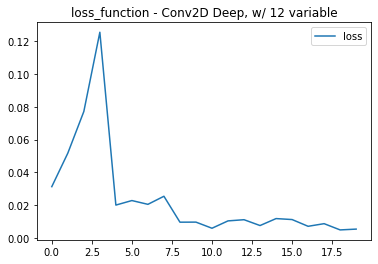

In [44]:
plt.plot(lstm_history.history["loss"])
plt.title("loss_function - Conv2D Deep, w/ 12 variable")
plt.legend(["loss"])
plt.show()

In [45]:
lstm_model.evaluate(X_test, y_test, verbose=0)

0.0077564227394759655

In [46]:
from sklearn.metrics import r2_score
predictions = lstm_model.predict(X_test)
test_r2 = r2_score(y_test, predictions[:,0])
test_r2

-0.22754113050130842

In [47]:
conv_acc_df = pd.DataFrame()
conv_acc_df['Actual'] = y_test
conv_acc_df['Predict'] = predictions[:,0]
conv_acc_df.head(10)

,Actual,Predict
0,1.002574,0.994727
1,1.015262,0.997272
2,0.986748,1.002053
3,1.007658,1.007126
4,0.984575,1.012547
5,0.985933,1.018156
6,0.979144,1.026750
7,1.006898,1.037965
8,0.972844,1.052661
9,0.952786,1.063612


In [48]:
predictions.shape

(124, 1)

In [49]:
y_test.shape

(124,)

In [50]:
# Save model
os.chdir("../ml")
lstm_model.save('model.h5')

NotImplementedError: Layer ModuleWrapper has arguments in `__init__` and therefore must override `get_config`.

---

## LSTM Evaluation

In [ ]:
from keras.models import load_model
os.chdir("../ml")
loaded_model = load_model('model.h5')

In [ ]:
loaded_model

---

### Load production test data

In [ ]:
test_end_date  = datetime.now()
test_start_date  = (test_end_date - timedelta(days=14))

test_start_date = test_start_date.strftime('%Y-%m-%d')
test_end_date = test_end_date.strftime('%Y-%m-%d')

print(f"Start date : {test_start_date}")
print(f"End date : {test_end_date}")

In [ ]:
# load the dataset
test_tickers = ["ADSK"]
test_ohlcv_df = alpaca.ohlcv(test_tickers, start_date=start_date, end_date=end_date)
test_tech_ind = technicals.TechnicalAnalysis(test_ohlcv_df)

test_df = test_tech_ind.get_all_technicals(test_tickers[0])
test_df.head()